In [1]:
# imports and configuration
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import configparser

import skill_metrics as sm

import modules.load_data as ld

def get_metrics(O,P):
    #ensure no nans in data
    idx = ~np.isnan(O)*~np.isinf(O)
    idx*= ~np.isnan(P)*~np.isinf(P)
    O = O[idx]
    P = P[idx]
    # precalculation
    N = len(O)
    N1 = 1./float(N)
    N2 = 1./(float(N)+1.)
    DELTA = P-O
    SUM = P+O
    # MBE
    MBE = N1 * np.sum(DELTA)
    # RMSE
    RMSE = np.sqrt(N2*np.sum(DELTA**2))
    # R
    ccoef = np.corrcoef(P,O)
    ccoef = ccoef[0][1]
    return MBE,RMSE,ccoef

stations= ld.dwd_stations()
stations = stations.where(stations.station!='ZG',drop=True)

models = np.array([
                   'MRM61',
                   'ESRA',
                   'Heliosat1I',
                   'SOLISsimple',
                   'CEM',
                   'MMAC',
                   'METSTAT',
                  ])


models_label = np.array([
                         'MRM v6.1',
                         'ESRA',
                         'Heliosat-1',
                         'Solis simple',
                         'CEM',
                         'MMAC',
                         'METSTAT',
 
                        ])




config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']

## Prepare Dataset
REari simulated with T-CARS and the CSF method are stored in two datasets. The gridded T-CARS dataset "ECRAD" is interpolated to each of the DWD stations. The interpolated values are stored in "ECDWD". 

In [2]:
ECRAD = xr.open_dataset(os.path.join(pf,"REari_TCARS2DWD.nc"))
# bias correction
ECRAD.REari_sfc.values = ECRAD.REari_sfc.values+1.5
ECRAD.REari_toa.values = ECRAD.REari_toa.values-0.6

DWD = xr.open_dataset(os.path.join(pf,"REari_CSF2DWD.nc"))

# ECRAD on DWD stations
ECDWD_sfc = np.zeros((len(ECRAD.day),len(DWD.station),len(DWD.model)))*np.nan
ECDWD_toa = np.zeros((len(ECRAD.day),len(DWD.station),len(DWD.model)))*np.nan
coords = dict(day = ECRAD.day,
              station = DWD.station,
              model = DWD.model)
for s,station in enumerate(stations.station.values):
    st = stations.sel(station=station)
#     EC = ECRAD.interp(lat=st.latitude.values,lon=st.longitude.values)
    EC = ECRAD.sel(station=station)
    for m,model in enumerate(models):
        ARE = DWD.ARE_csf.sel(station=station,model=model)
        ARE[ARE>=0]=np.nan
        idx = ~np.isnan(ARE.values)*~np.isnan(EC.REari_sfc.values)
        ECDWD_sfc[:,s,m] = EC.REari_sfc.where(idx)
        ECDWD_toa[:,s,m] = EC.REari_toa.where(idx)

ECDWD = xr.Dataset({'ARE_sfc':(('day','station','model'),ECDWD_sfc),
                    'ARE_toa':(('day','station','model'),ECDWD_toa)},
                   coords=coords)

In [3]:
DWD

<xarray.Dataset>
Dimensions:       (day: 365, model: 7, station: 26)
Coordinates:
  * day           (day) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
  * station       (station) object 'AK' 'BG' 'BN' 'CH' ... 'TR' 'WN' 'WZ' 'ZG'
  * model         (model) object 'MRM61' 'MMAC' ... 'METSTAT' 'SOLISsimple'
Data variables:
    ARE_csf       (day, station, model) float64 ...
    ARE_csf_noal  (day, station, model) float64 ...
    A_csf         (day, station, model) float64 ...

In [4]:
# modified taylor plot from skill_metrics package
# added options to change FontSize
def plot_taylor(*args,**kwargs):
    from skill_metrics.taylor_diagram import _get_taylor_diagram_arguments
    try:
        marker_fontsize = kwargs.pop('markerFontSize')
    except:
        marker_fontsize = 10
    fontSize = rcParams.get('font.size')        
    try:
        axlabel_fontsize = kwargs.pop('axlabelFontSize')
    except:
        axlabel_fontsize = fontSize
    
    nargin = len(args)
    STDs, RMSs, CORs = _get_taylor_diagram_arguments(*args,**kwargs)
    
    if nargin == 0: return

    # Get options
    option = sm.get_taylor_diagram_options(CORs,**kwargs)

    # Check the input statistics if requested.
    if option['checkstats'] == 'on':
        sm.check_taylor_stats(STDs, RMSs, CORs, 0.01)

    # Express statistics in polar coordinates.
    rho   = STDs
    theta = np.arccos(CORs)

    #  Get axis values for plot
    axes, cax = sm.get_taylor_diagram_axes(rho,option)

    if option['overlay'] == 'off':
        # Draw circles about origin
        rcParams['font.size']=14
        sm.overlay_taylor_diagram_circles(axes,cax,option)
        # Draw lines emanating from origin
        sm.overlay_taylor_diagram_lines(axes,cax,option);
        rcParams['font.size']=fontSize
        # Plot axes for Taylor diagram
        rcParams['font.size']=axlabel_fontsize
        ax = sm.plot_taylor_axes(axes,cax,option)
        rcParams['font.size']=fontSize
        
        # Plot marker on axis indicating observation STD
        sm.plot_taylor_obs(axes,STDs[0],axes,option);

    # Plot data points. Note that only rho[1:N] and theta[1:N] are 
    # plotted.
    X = np.multiply(rho[1:],np.cos(theta[1:]))
    Y = np.multiply(rho[1:],np.sin(theta[1:]))

    lowcase = option['markerdisplayed'].lower()
    if lowcase == 'marker':
        rcParams['font.size']=marker_fontsize
        sm.plot_pattern_diagram_markers(X,Y,option)
        rcParams['font.size']=fontSize 
    elif lowcase == 'colorbar':
        nZdata = len(option['cmapzdata'])
        if nZdata == 0:
            # Use Centered Root Mean Square Difference for colors
            sm.plot_pattern_diagram_colorbar(X,Y,RMSs[1:],option)
        else:
            # Use Bias values for colors
            sm.plot_pattern_diagram_colorbar(X,Y,option['cmapzdata'][1:],option)
    else:
        raise ValueError('Unrecognized option: ' + 
                         option['markerdisplayed'])

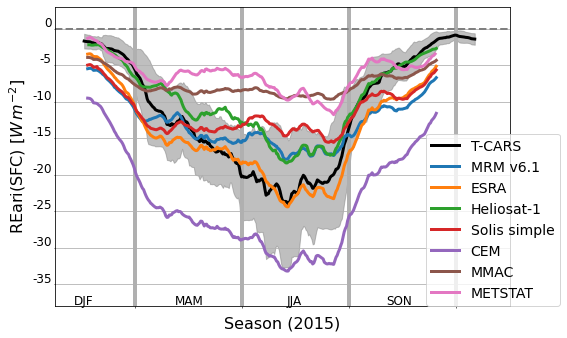

In [5]:
### FIG08
#### Annual overview

plt.figure(figsize=(8,4.8))#figsize=(8,5)

# EARE = xr.DataArray(np.median(ECRAD.REari_sfc,axis=[1,2]),dims={'day':ECRAD.day})
EARE = ECRAD.REari_sfc.mean(dim='station',skipna=True)

ARE = EARE.rolling(day=30,center=True).mean()
dARE = EARE.rolling(day=30,center=True).std()
plt.fill_between(np.arange(len(ECRAD.day)),ARE-dARE,ARE+dARE,color=(0.5,0.5,0.5),alpha=0.5)
plt.plot(np.arange(len(ECRAD.day)),ARE,color='k',linewidth=3,label='T-CARS')


for m,model in enumerate(zip(models,models_label)):
    model,mlabel=model
    ARE = DWD.ARE_csf.sel(model=model).mean(dim='station',skipna=True).interpolate_na(dim='day').rolling(day=30,center=True).mean(skipna=True)

    plt.plot(ARE,linestyle='-',linewidth=3,label = mlabel)

plt.axhline(0,linestyle='--',linewidth=2,color=(0.5,0.5,0.5))

# plt.ylim([-80,0])    
plt.legend(fontsize=14,bbox_to_anchor=(0.8, 0.6))#bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
ax=plt.gca()
ax.set_xlim([-10,380])
ax.set_ylim([-38,3])
# config axis labels
ax.set_xticks(np.linspace(15,285,4))
ax.set_yticks(np.arange(-35,5,5)+1)
ax.set_xticklabels(['DJF','MAM','JJA','SON'])#,fontweight='bold')
ax.set_yticklabels(np.arange(-35,5,5),fontsize=10)
ax.tick_params('x',color='',length=0,pad=-12,labelsize='large')
ax.tick_params('y',color='',length=0,labelsize='large',labelleft=True,labelright=False)#pad=-25
# config for gridlines
ax.set_xticks(np.linspace(59,334,4),minor=True)
ax.set_yticks(np.arange(-35,5,5),minor = True)
ax.grid(which='minor')
ax.tick_params('x',which='minor',grid_linewidth=4)
ax.tick_params('y',which='minor',color='k',length=1,pad=-20)
ax.set_xlabel('Season (2015)',fontsize=16)#,fontweight='bold')


plt.ylabel(r'REari(SFC) $\left[W\,m^{-2}\right]$',fontsize=16)#,fontweight='bold')
plt.tight_layout()
plt.savefig('Figures/Fig08.pdf',dpi=300,bbox_inches='tight')


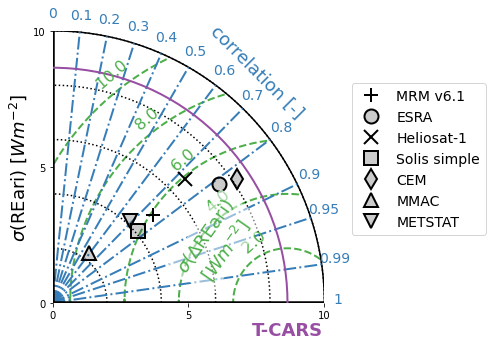

In [6]:
## FIG 09
first=True
plt.figure(figsize=(10,5))#
for m,model in enumerate(models):
    label = f"{models_label[m]}"
    
    # get REari (ARE) from CSM and T-CARS dataset
    ARE = DWD.ARE_csf.sel(model=model).mean(dim=['station'],skipna=True)
    ARE[ARE>=0]=np.nan
    ARE_EC = ECDWD.ARE_sfc.sel(model=model).mean(dim=['station'],skipna=True)
    ARE_EC[ARE_EC>=0]=np.nan
    
    # drop values if nan
    idx = ~np.isnan(ARE.values)*~np.isnan(ARE_EC.values)
    ref = {'data':np.array(ARE_EC.values[idx])}
    pred = {'data':np.array(ARE.values[idx])}
    
    # calculate annual standard deviation, centered RMSR (crmsd) and
    # correlation coefficient
    taylor_stats = sm.taylor_statistics(pred,ref,'data')
    if np.any(np.isnan(np.array([taylor_stats['sdev'][1],
                                 taylor_stats['crmsd'][1],
                                 taylor_stats['ccoef'][1]]))):
        continue
        
    SSDEV0 = taylor_stats['sdev'][0]
    SSDEV = taylor_stats['sdev'][1]
    CORR = taylor_stats['ccoef'][1]
    # We replace the cRMSE defined in the skill_metrics module
    # as the standard deviation of REari(CSM)-REari(TCARS)
    # for large enough datasets, they become about equal
    # RMSE = taylor_stats['crmsd'][1]
    RMSE = np.nanstd(pred['data']-ref['data'])
    
    # Add metrics for each CSM, lists start with the T-CARS reference
    if first:
        first=False
        labels = ['T-CARS',label]
        ssdev = [SSDEV0, SSDEV]
        crmsd = [0., RMSE]
        ccoef = [1., CORR]
    else:
        labels.append(label)
        ssdev.append(SSDEV)
        crmsd.append(RMSE)
        ccoef.append(CORR)


ssdev = np.array(ssdev)
crmsd = np.array(crmsd)
ccoef = np.array(ccoef)

## do the taylor diagramm
plot_taylor(ssdev,crmsd,ccoef,numberpanels=1,
            axlabelFontSize=18,
            markerLabel=labels,
            markerFontSize=16,
            markerSize=14,
            markerLegend='on',
            markercolor='k',
            alpha = 0.2,
            colRMS='#4daf4a',
            widthRMS=2,
            titleRMSDangle=130,
            colCOR='#377eb8',
            widthCOR=2,
            styleOBS='-',
            widthOBS=2,
            colOBS='#984ea3',
            titlestd=False,
            titlerms=False,
            titleOBS='',
            titleCOR=False)

## add custom axis labels
plt.text(6,2.2,r'$\sigma$($\Delta$REari)'+'\n'+r'$\left[Wm^{-2}\right]$',
         color='#4daf4a',fontsize=18,#fontweight='bold',
         rotation =55,va='center',ha='center',
         bbox = dict(color='w', alpha=0.5,mutation_scale=16))
plt.text(7.5,8.5,'correlation [-]',color='#377eb8',fontsize=18,rotation =-45,va='center',ha='center')
plt.text(ssdev[0],-1,'T-CARS',color='#984ea3',fontsize=18,fontweight='bold',rotation =0,va='center',ha='center')
plt.ylabel(r'$\sigma$(REari) $\left[Wm^{-2}\right]$',fontsize=18)#,fontweight='bold')
plt.savefig('Figures/Fig09.pdf',dpi=300,bbox_inches='tight')


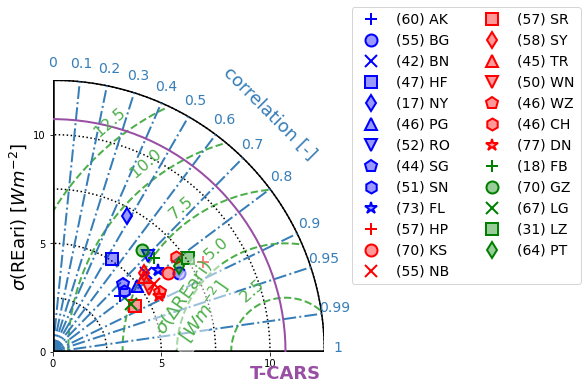

In [7]:
### FIG 10
first=True

fig=plt.figure(figsize=(13,5))#(11,5)
# iterate over DWD stations
# sorted by taggs , therefore the legend colors will be sorted
for station in ['AK','BG','BN','HF','NY','PG','RO','SG','SN', # northern stations
                'FL','HP','KS','NB','SR','SY','TR','WN','WZ', # southern stations
                'CH','DN','FB','GZ','LG','LZ','PT']: # more stations
    st = stations.sel(station=station)
    label = f"{st.name.values}"
    label = station
    mi=0
    ARE = DWD.ARE_csf.sel(station=station).mean(dim=['model'],skipna=True)
    ARE[ARE>=0] = np.nan
    ARE_EC = ECDWD.ARE_sfc.sel(station=station).mean(dim=['model'],skipna=True)
    ARE_EC[ARE_EC>=0] = np.nan
    idx = ~np.isnan(ARE.values)*~np.isnan(ARE_EC.values)
    N = np.count_nonzero(idx)
    label = f"({N}) "+label
    ref = {'data':np.array(ARE_EC.values[idx])}
    pred = {'data':np.array(ARE.values[idx])}
    
    # calculate annual standard deviation, centered RMSR (crmsd) and
    # correlation coefficient
    taylor_stats = sm.taylor_statistics(pred,ref,'data')
    if np.any(np.isnan(np.array([taylor_stats['sdev'][1],
                                 taylor_stats['crmsd'][1],
                                 taylor_stats['ccoef'][1]]))):
        continue
        
    SSDEV0 = taylor_stats['sdev'][0]
    SSDEV = taylor_stats['sdev'][1]
    CORR = taylor_stats['ccoef'][1]
    # We replace the cRMSE defined in the skill_metrics module
    # as the standard deviation of REari(CSM)-REari(TCARS)
    # for large enough datasets, they become about equal
    # RMSE = taylor_stats['crmsd'][1]
    RMSE = np.nanstd(pred['data']-ref['data'])
    
    # Add metrics for each CSM, lists start with the T-CARS reference
    if first:
        first=False
        labels = ['T-CARS',label]
        ssdev = [SSDEV0, SSDEV]
        crmsd = [0., RMSE]
        ccoef = [1., CORR]
    else:
        labels.append(label)
        ssdev.append(SSDEV)
        crmsd.append(RMSE)
        ccoef.append(CORR)


ssdev = np.array(ssdev)
crmsd = np.array(crmsd)
ccoef = np.array(ccoef)
plot_taylor(ssdev,crmsd,ccoef,numberpanels=1,
            axlabelFontSize=16,
            markerLabel=labels,
            markerFontSize=16,
            markerSize=12,
            markerLegend='on',
            markercolor='k',
            alpha = 0.4,
            colRMS='#4daf4a',
            widthRMS=2,
            titleRMSDangle=130,
            colCOR='#377eb8',
            widthCOR=2,
            styleOBS='-',
            widthOBS=2,
            colOBS='#984ea3',
            titlestd=False,
            titlerms=False,
            titleobs='',
            titlecor=False)


plt.text(6.5,2.2,r'$\sigma$($\Delta$REari)'+'\n'+r'$\left[Wm^{-2}\right]$',
         color='#4daf4a',fontsize=18,
         rotation =55,va='center',ha='center',
         bbox = dict(color='w', alpha=0.5,mutation_scale=16))
# plt.text(7.5,8.5,'correlation [-]',color='#377eb8',fontsize=18,rotation =-45,va='center',ha='center')
plt.text(10,11,'correlation [-]',color='#377eb8',fontsize=18,rotation =-45,va='center',ha='center')
plt.text(ssdev[0],-1,'T-CARS',color='#984ea3',fontsize=18,fontweight='bold',rotation =0,va='center',ha='center')
plt.ylabel(r'$\sigma$(REari) $\left[Wm^{-2}\right]$',fontsize=18)
plt.savefig('Figures/Fig10.pdf',dpi=300,bbox_inches='tight')
